# The neural representation of self is recapitulated in the brains of friends: a round-robin fMRI study

Analysis notebook to generate all results and figures from:
<br> Chavez, R.S., Wagner, D.D. The neural representation of self is recapitulated in the brains of friends: a round-robin fMRI study.

Author: Robert S. Chavez <br>
Date: February 15th, 2018

In [ ]:
# Load packages
# Notes:
# In case packages are not already installed:
# install.packages(c("dplyr", "ggplot2", "reshape2", "lme4", "lmerTest", "BayesFactor", "rstanarm"))
# If having problems compiling igraphs dependency for rstanarm on Linux systems make sure
# you have libxml2-dev installed (via apt-get). 
library(dplyr)
library(ggplot2)
library(reshape2)
library(lme4)
library(lmerTest)
library(BayesFactor)
library(rstanarm)

## Read in the fMRI dataset and arrange dataframes for analysis.

Below, we read in the multivoxel fMRI data for each participant in the round-robin task. The fMRI data represents each voxel's beta estimates from the a vMPFC region of interest independently defined based on a seperate self/bush/case localizer task (see manuscript for more details).

Note, we will load the behavioral trait ratings dataset in later section below.

In [2]:
# Read in multivoxel fMRI data from the indepently deficed VMPFC ROI dervied from
# the self/bush localizer task (see manuscript for more details)
zstats <-  read.table("./fmri_vmpfc_betas", quote="\"", comment.char="",skip = 3) 

# Create and assign subject and target variables
sub <- c(rep(1,11), rep(2,11), rep(3,11), rep(4,11), rep(5,11), rep(6,11), 
                rep(7,11), rep(8,11), rep(9,11), rep(10,11), rep(11,11)) 
zstats$sub <- as.factor(sub)
tar <- rep(rep(1:11),11)
zstats$tar <- as.factor(tar)

# Main data frame
psynet_fmri <- zstats %>% select(sub, tar, contains("V"))

# No-self condition data frame
psynet_noself_fmri <- psynet_fmri
for(i in 1:length(psynet_noself_fmri$sub)){
    if(psynet_noself_fmri[i,1] == psynet_noself_fmri[i,2]){
    psynet_noself_fmri[i,] <-c(psynet_noself_fmri[i,1],psynet_noself_fmri[i,2],rep(NA, length(psynet_noself_fmri[1,])-2))  
      }
}

# Removes NAs from data frame
psynet_noself_fmri_noNA <- psynet_fmri %>% filter(sub != tar) 
  
# Only-self condition data frame
psynet_selfonly_fmri <- psynet_fmri %>% filter(sub == tar)

## fMRI self/other correspondence analysis

The following analysis examines whether there a relationship between a person's brain activity for self and the brain activity of their peers when those peers are thinking about that person. Specifically, the code below calculates the following for each participant:

1. Congruent correlation (_self_ with peers thinking of that _self_)
1. Incongruent correlations (_self_ with peers thinking about another participant's_self_). 

Finally, we plot the data with the output corresponding to Figure 3 from the manuscript.

Warning message:
: Removed 11 rows containing missing values (geom_errorbar).

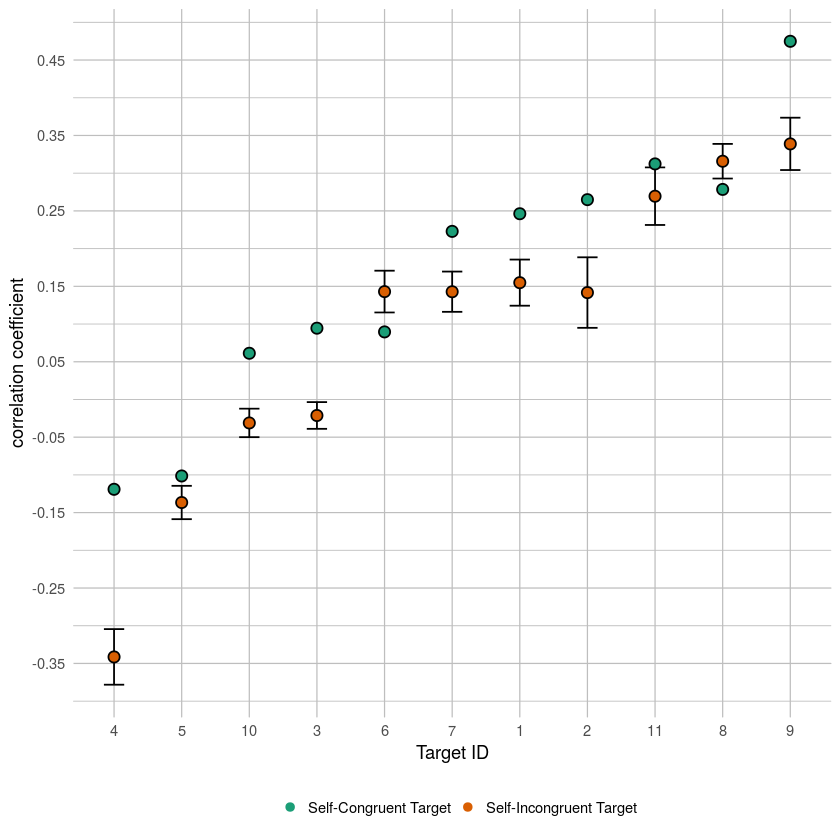

In [3]:
# Calcuate correlation vectors
cor_vec <- vector()

for(s in 1:11){
  
  self_values <-  psynet_selfonly_fmri %>% filter(sub==s) %>% select(-sub,-tar) 
  self_values <- as.numeric(self_values[1,])
  
  for(t in  1:11){
    temp <- psynet_noself_fmri_noNA %>% filter(tar == t, sub != s) %>% select(-sub,-tar) 
    agg_values <- apply(temp,2,mean,na.rm=TRUE)
    cor_vec <- c(cor_vec,cor(agg_values,self_values,method = 'spearman'))
    }
  }

# Create plotting data frame
psynet_fmri_consensus <- psynet_fmri%>% select(sub,tar)
psynet_fmri_consensus$cor_vec <- cor_vec

# Summarize for plotting
psynet_fmri_consensus$condition <- ifelse(psynet_fmri$sub == psynet_fmri$tar, "Correct", "Incorrect")
psynet_fmri_consensus$condition <- factor(psynet_fmri_consensus$condition, levels = c("Correct", "Incorrect"))
psynet_fmri_consensus$correct_corr <- ifelse(psynet_fmri_consensus$condition == "Correct",cor_vec,NA)
psynet_fmri_consensus$incorrect_corr <- ifelse(psynet_fmri_consensus$condition == "Correct",NA,cor_vec)
psynet_fmri_consensus$sub <- factor(psynet_fmri_consensus$sub, levels=levels(reorder(psynet_fmri_consensus$sub, -psynet_fmri_consensus$cor_vec)))

# Define standard error funciton
ste <- function (x, na.rm = FALSE){
    if (na.rm) 
        x <- x[!is.na(x)]
        sd(x)/sqrt(length(x))
        }

# Create data frame for plotting
df <- psynet_fmri_consensus %>% group_by(sub,condition) %>% summarise(mean = mean(cor_vec), se=ste(cor_vec))
df$sub <- factor(df$sub, levels=levels(reorder(df$sub, df$mean)))
df$condition <- ifelse(df$condition == "Correct","Self-Congruent Target","Self-Incongruent Target")

# Plot
ggplot(df,aes(as.factor(sub),mean)) + 
  geom_errorbar(aes(ymin=mean-se, ymax=mean+se), colour="black", width=.3) +
  geom_point(color='black',size=3) +
  geom_point(aes(color=as.factor(condition)),size=2) +
  scale_color_brewer(palette = "Dark2", name=element_blank()) + 
  theme_minimal() + scale_y_continuous(breaks=seq(-.35,.50,.1)) +
  theme(panel.grid.minor= element_line(color = "grey"),
        panel.grid.major= element_line(color = "grey"),
        panel.grid.major.x = element_line(color = "grey"), 
        legend.position = 'bottom') +
  labs(x = "Target ID", y= "correlation coefficient")

## fMRI self/other correspondence analysis
### Frequentist MLM

Here we test if there is a greater values for congruent vs incongruent correlations in a multi-level model using the lme4 package with parameter p-values calculated using the lmerTest package.

In [4]:
# Make variables factors
psynet_fmri_consensus$sub <- as.factor(psynet_fmri_consensus$sub)
psynet_fmri_consensus$condition <- factor(psynet_fmri_consensus$condition, levels = c('Incorrect','Correct') )

# lme4
fit_lmm_fmri <- lmer(cor_vec ~ condition + (1|sub), REML = F, data = psynet_fmri_consensus)

# Print lmer results
summary(fit_lmm_fmri)

Linear mixed model fit by maximum likelihood t-tests use Satterthwaite
  approximations to degrees of freedom [lmerMod]
Formula: cor_vec ~ condition + (1 | sub)
   Data: psynet_fmri_consensus

     AIC      BIC   logLik deviance df.resid 
  -177.3   -166.1     92.7   -185.3      117 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.8548 -0.5242  0.1191  0.5512  2.2883 

Random effects:
 Groups   Name        Variance Std.Dev.
 sub      (Intercept) 0.036280 0.19047 
 Residual             0.008945 0.09458 
Number of obs: 121, groups:  sub, 11

Fixed effects:
                  Estimate Std. Error        df t value Pr(>|t|)  
(Intercept)        0.08877    0.05813  11.05000   1.527   0.1549  
conditionCorrect   0.07713    0.02991 110.00000   2.579   0.0112 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
condtnCrrct -0.047

## fMRI self/other correspondence analysis
### Bayesian MLM
Below we estimate the effect size of this design using Stan via the rstanarm package. From here, we will calculated a 95% posterior interval around the estimated effect size using a _weakly informative_ Gaussian prior (see: [https://cran.r-project.org/web/packages/rstanarm/vignettes/priors.html](https://cran.r-project.org/web/packages/rstanarm/vignettes/priors.html)).

Note that due to the stochastic nature of this process, the computed 95% posterior intervel computed below may differ slightly from that reported in the manuscript.

In [5]:
# Fit model
sfit <- stan_lmer(cor_vec ~ condition  + (1|sub), prior=normal(),  data = psynet_fmri_consensus)


SAMPLING FOR MODEL 'continuous' NOW (CHAIN 1).

Gradient evaluation took 0.00012 seconds
1000 transitions using 10 leapfrog steps per transition would take 1.2 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1600 / 2000 [ 80%]  (Sampling)
Iteration: 1800 / 2000 [ 90%]  (Sampling)
Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 1.91443 seconds (Warm-up)
               1.45787 seconds (Sampling)
               3.3723 seconds (Total)


SAMPLING FOR MODEL 'continuous' NOW (CHAIN 2).

Gradient evaluation took 4e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.4 seconds.
Adjust 

In [6]:
# Calculate posterior interval 
ci95 <- posterior_interval(sfit, prob = .95)
ci95

,2.5%,97.5%
(Intercept),-0.03761817,0.22463420
conditionCorrect,0.0175153,0.1365627
b[(Intercept) sub:9],0.1083182,0.3856493
b[(Intercept) sub:8],0.07011641,0.34832776
b[(Intercept) sub:11],0.03374929,0.30837537
b[(Intercept) sub:1],-0.07519496,0.19829595
b[(Intercept) sub:2],-0.08427878,0.18893385
b[(Intercept) sub:7],-0.08823852,0.18945291
b[(Intercept) sub:6],-0.1015629,0.1765665
b[(Intercept) sub:3],-0.24144259,0.02797343


## Behavioral trait ratings analysis

The section below loadsloads the raw trait ratings data from the behavioral sesssion (see manuscript for more details) and restructures it for use in the neural/behavioral correlations that follow.

In [7]:
# Load behavioral data.
ratings_data <- read.csv("./behavioral_ratings.csv")[,-1] 

# Melt data frame to aggregate across constructs 
ratings_melt <- melt(ratings_data, variable.name = 'rater')
ratings_melt$rater <- gsub("s","", ratings_melt$rater)
ratings_melt$target <- gsub("tar","", ratings_melt$target)

ratings_melt_sum <- ratings_melt %>% group_by(rater,target,construct) %>% summarise(value = mean(value))
ratings_melt_sum_noself <- ratings_melt_sum %>% filter(rater != target)
 
# Create data frames structured by either rater, target, or construct
ratings_sum_rater <- dcast(ratings_melt_sum, construct*target~rater)

# Create data frames the same data frames without the self condition included
ratings_sum_rater_noself <- dcast(ratings_melt_sum_noself, construct*target~rater)

# Unaggregated data
ratings_rater <-  dcast(ratings_melt, question*construct*target~rater)

Using construct, question, target as id variables


## Aggregated trait ratings for each target

The code below calculates the aggregated responses for each correct/incorrect target pair, mirroring the analyses of the neural data above. This analysis is based on round-robin trait ratings task (e.g., TIPI, stereotype content model, etc.) collected during a seperate behavioral session. See the manuscript for a description of the specific traits collected. 

In [8]:
n <- 0
behav_cor_vec <- vector()
for(sub in unique(ratings_rater$target)){
  for(tar in unique(ratings_rater$target)){
    n <- n + 1 
    if(sub == tar){
      cmd1 <- paste("agg_data <- ratings_sum_rater_noself %>% 
                    filter(construct ==  'openness' | 
                    construct ==  'conscientiousness' | 
                    construct ==  'agreeableness' |
                    construct ==  'extraversion' |
                    construct ==  'neuroticism' |
                    construct ==  'warmth'|
                    construct ==  'competence' |
                    construct ==  'selfesteem' |
                    construct ==  'dominant' |
                    construct ==  'caring' |
                    construct ==  'emotionally stable' |
                    construct ==  'weird' |
                    construct ==  'trustworthy' |
                    construct ==  'mean' |
                    construct ==  'responsible'|
                    construct ==  'sociable'|
                    construct ==  'unhappy') %>%  
                    filter(target =='", sub,"') %>%
                    select(-construct,  -target,-`",sub,"`) %>% 
                    apply(1,mean, na.rm=TRUE)", sep="")
      eval(parse(text = cmd1))
      
      cmd2 <- paste("self_data <- ratings_sum_rater %>%
                    filter(construct ==  'openness' | 
                    construct ==  'conscientiousness' | 
                    construct ==  'agreeableness' |
                    construct ==  'extraversion' |
                    construct ==  'neuroticism' |
                    construct ==  'warmth'|
                    construct ==  'competence' |
                    construct ==  'selfesteem' |
                    construct ==  'dominant' |
                    construct ==  'caring' |
                    construct ==  'emotionally stable' |
                    construct ==  'weird' |
                    construct ==  'trustworthy' |
                    construct ==  'mean' |
                    construct ==  'responsible'|
                    construct ==  'sociable'|
                    construct ==  'unhappy') %>% 
                    filter(target == '",sub,"') %>%
                    select(`",sub,"`)", sep="")
      eval(parse(text = cmd2))
      behav_cor_vec[n] <- cor(agg_data,self_data[,1],method = "spearman")
      
    } else {
      cmd1 <- paste("agg_data <- ratings_sum_rater_noself %>% 
                    filter(construct ==  'openness' | 
                    construct ==  'conscientiousness' | 
                    construct ==  'agreeableness' |
                    construct ==  'extraversion' |
                    construct ==  'neuroticism' |
                    construct ==  'warmth'|
                    construct ==  'competence' |
                    construct ==  'selfesteem' |
                    construct ==  'dominant' |
                    construct ==  'caring' |
                    construct ==  'emotionally stable' |
                    construct ==  'weird' |
                    construct ==  'trustworthy' |
                    construct ==  'mean' |
                    construct ==  'responsible'|
                    construct ==  'sociable'|
                    construct ==  'unhappy') %>% 
                    filter(target == '",tar,"') %>%
                    select(-construct,-target,`",sub,"`) %>% 
                    apply(1,mean, na.rm=TRUE)", sep ="")
      eval(parse(text=cmd1))
      
      cmd2 <- paste("self_data <- ratings_sum_rater %>%
                    filter(construct ==  'openness' | 
                    construct ==  'conscientiousness' | 
                    construct ==  'agreeableness' |
                    construct ==  'extraversion' |
                    construct ==  'neuroticism' |
                    construct ==  'warmth'|
                    construct ==  'competence' |
                    construct ==  'selfesteem' |
                    construct ==  'dominant' |
                    construct ==  'caring' |
                    construct ==  'emotionally stable' |
                    construct ==  'weird' |
                    construct ==  'trustworthy' |
                    construct ==  'mean' |
                    construct ==  'responsible'|
                    construct ==  'sociable'|
                    construct ==  'unhappy') %>% 
                    filter(target == '",sub,"') %>%
                    select(`",sub,"`)",sep="")
      eval(parse(text=cmd2))
      behav_cor_vec[n] <- cor(agg_data,self_data[,1],method = "spearman")
      
    }
  }
}

psynet_fmri_consensus$behav_cor_vec <- behav_cor_vec

## Neural and behavioral correlation
The code sections below test the correlation between neural and behavioral agreement ratings in both a frequentist and bayesian framework.

### Frequentist correlaiton
Below is a simple frequentist correlation between the behavioral and neural accuracy between the two predictors.

In [9]:
# Subset and reorder factors
psynet_fmri_consensus_correctonly <- psynet_fmri_consensus %>% filter(condition =="Correct")

cor.test(psynet_fmri_consensus_correctonly$cor_vec, 
         psynet_fmri_consensus_correctonly$behav_cor_vec,
         method='pearson')


	Pearson's product-moment correlation

data:  psynet_fmri_consensus_correctonly$cor_vec and psynet_fmri_consensus_correctonly$behav_cor_vec
t = 3.0215, df = 9, p-value = 0.01444
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.1910999 0.9185054
sample estimates:
      cor 
0.7096261 


## Bayes Factor regression
The code below calculates Bayes Factor for the linear model predicting neural correlations from behavioral ones.

In [10]:
regressionBF(cor_vec ~ behav_cor_vec, data = psynet_fmri_consensus_correctonly)

Bayes factor analysis
--------------
[1] behav_cor_vec : 4.069686 ±0%

Against denominator:
  Intercept only 
---
Bayes factor type: BFlinearModel, JZS


## Calculate range of neural/behavioral correlations
The code below calculates the range of neural/behavioral correlations, generating the values used in the manuscript.

In [11]:
range(psynet_fmri_consensus_correctonly$behav_cor_vec)

[1] 0.4137632 0.8610039

## Plot neural/behavioral correlation within each subject

Below is the normalized plot of the correlation. Red dots are the behavioral correlations and blue dots are the neural correlations. Overall there is a high degree of correspondence in accuracy between the two different measures, such that gerater accuracy in person perception is associated with greater neural similarity between self and peers for that target.

Using sub as id variables
Using sub as id variables
Warning message:
: attributes are not identical across measure variables; they will be dropped

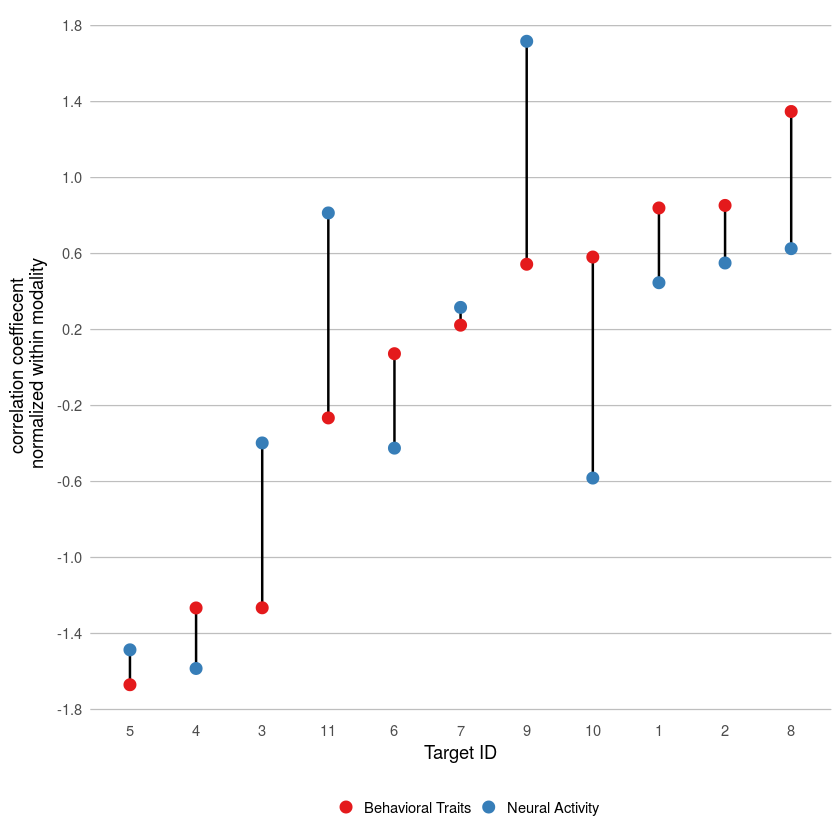

In [12]:
# Create data frame
psynet_fmri_consensus_correctonly$sub <- factor(psynet_fmri_consensus_correctonly$sub,
                                                levels=levels(reorder(psynet_fmri_consensus_correctonly$sub,
                                                                      psynet_fmri_consensus_correctonly$behav_cor_vec))) 

melt_correct_consensus <- psynet_fmri_consensus_correctonly %>% 
  select(sub, behav_cor_vec, cor_vec) %>%  
  melt()

psynet_fmri_consensus_correctonly2 <- psynet_fmri_consensus_correctonly

# Scale the values (i.e. normalize within behavioral/neural modality)
psynet_fmri_consensus_correctonly2$behav_cor_vec <- scale(psynet_fmri_consensus_correctonly2$behav_cor_vec)
psynet_fmri_consensus_correctonly2$cor_vec <- scale(psynet_fmri_consensus_correctonly2$cor_vec)

# Plot results within subject
melt_correct_consensus2 <- psynet_fmri_consensus_correctonly2 %>% select(sub, behav_cor_vec, cor_vec) %>%  melt()

ggplot(melt_correct_consensus2, aes(sub, value, color = variable, group=sub)) + 
  geom_line(color= 'black', size = .7 ) +
  geom_point(size = 3) +
  scale_color_brewer(palette = 'Set1',
                     labels=c("Behavioral Traits","Neural Activity"),
                     name="") + 
  labs(x = "Target ID", y= "correlation coeffiecent \nnormalized within modality") +
  scale_y_continuous(breaks=seq(-3, 3, 0.40)) + 
  theme_minimal() +
  theme(panel.grid.minor=element_blank(), 
        panel.grid.major= element_line(color = "grey"),
        panel.grid.major.x = element_blank(), 
        legend.position = 'bottom') 

## Additional plots for the manuscript
The code blow was used to generate additional plots for the manuscript that were otherwise not included as part of the analysis.

In [13]:
# Define the 'multiplot' function
multiplot2 <- function (..., plotlist = NULL, file, cols = 1, layout = NULL) 
{
    require(grid)
    plots <- c(list(...), plotlist)
    numPlots = length(plots)
    if (is.null(layout)) {
        layout <- matrix(seq(1, cols * ceiling(numPlots/cols)), 
            ncol = cols, nrow = ceiling(numPlots/cols))
    }
    if (numPlots == 1) {
        print(plots[[1]])
    }
    else {
        grid.newpage()
        pushViewport(viewport(layout = grid.layout(nrow(layout), 
            ncol(layout))))
        for (i in 1:numPlots) {
            matchidx <- as.data.frame(which(layout == i, arr.ind = TRUE))
            print(plots[[i]], vp = viewport(layout.pos.row = matchidx$row, 
                layout.pos.col = matchidx$col))
        }
    }
}

These are additional plots included in the paper showing example scatter plots of the congruent vs incongruent relationships.

Loading required package: grid


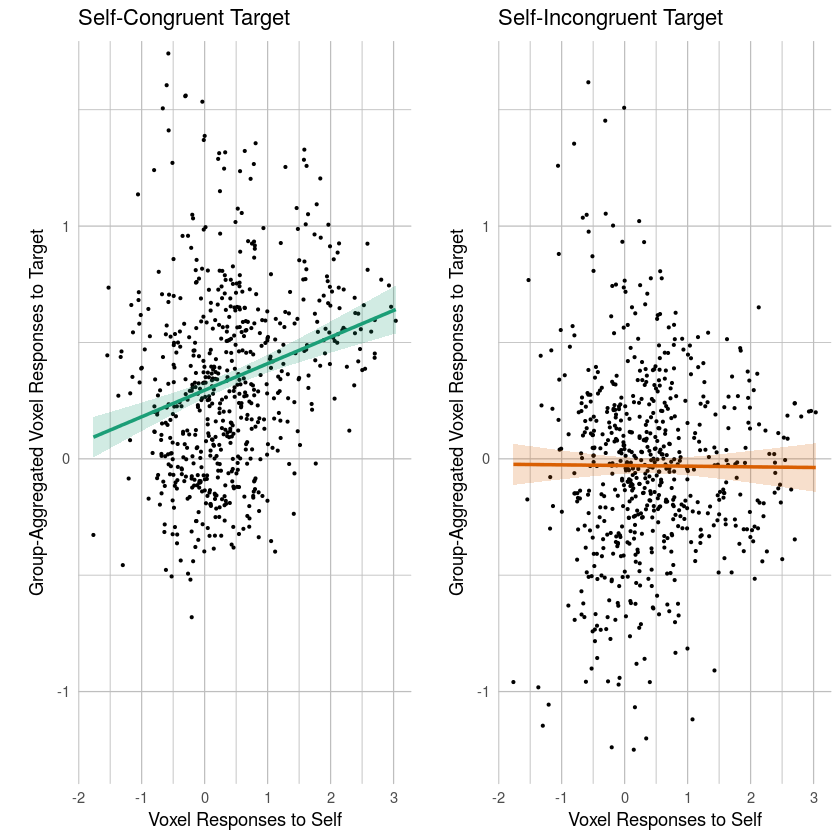

In [14]:
S1 <- psynet_fmri %>% 
  filter(sub == 2, tar == 2) %>% 
  select(-sub,-tar)
Self <- as.numeric(S1[1,])

T1 <- psynet_noself_fmri_noNA %>% 
  filter(tar == 2) %>% 
  select(-tar,-sub) %>% 
  apply(2,mean)
Congruent_Target <- as.numeric(T1)

T2 <- psynet_noself_fmri_noNA %>% 
  filter(tar == 6, sub !=2) %>% 
  select(-tar,-sub) %>% 
  apply(2,mean)
Incongruent_Target <- as.numeric(T2)

plot_df <- data.frame(Self,Congruent_Target,Incongruent_Target)

p1 <- ggplot(plot_df,aes(Self,Congruent_Target)) + 
  geom_point(size=0.5) +  
  geom_smooth(method = 'lm',fill="#1B9E77",color="#1B9E77",alpha=.2) + 
  theme_minimal()  + 
  theme(panel.grid.minor= element_line(color = "grey"), 
        panel.grid.major= element_line(color = "grey"),
        panel.grid.major.x = element_line(color = "grey")) +  
  coord_cartesian(ylim = c(-1.25,1.65)) + 
  labs(x="Voxel Responses to Self", 
       y = "\nGroup-Aggregated Voxel Responses to Target",
       title="Self-Congruent Target")

p2 <- ggplot(plot_df,aes(Self,Incongruent_Target)) + 
  geom_point(size=.5) + 
  geom_smooth(method = 'lm',fill="#D95F02",color="#D95F02",alpha=.2) + 
  theme_minimal() + 
  theme(panel.grid.minor= element_line(color = "grey"), 
        panel.grid.major= element_line(color = "grey"),
        panel.grid.major.x = element_line(color = "grey")) + 
  coord_cartesian(ylim = c(-1.25,1.65)) +
  labs(x="Voxel Responses to Self", 
       y = "\nGroup-Aggregated Voxel Responses to Target",
       title="Self-Incongruent Target")

multiplot2(p1,p2, cols = 2)